In [1]:
from brian2 import *
import matplotlib.pyplot as plt
import numpy as np

rpost1 = 30*Hz
rpost2 = 10*Hz
rpre = 60*Hz
N = 5000
T=3*second

rpost = TimedArray([rpost1,rpost2],dt=T/2)

post = PoissonGroup(N, rates='rpost(t)')
pre  = PoissonGroup(N, rates=rpre)

t_forw = 15*ms
t_back = 20*ms
A_forw = 7e-3
A_back = A_forw * t_forw/t_back

S = Synapses(pre, post,
         '''
         w : 1
         do_j1/dt  = -o_j1/t_forw   : 1 (event-driven)
         do_i1/dt  = -o_i1/t_back  : 1 (event-driven)
         do_j/dt   = (o_j1 - o_j)/t_forw  : 1 (event-driven) 
         do_i/dt   = (o_i1 - o_i)/t_back : 1 (event-driven) 
         ''',
         on_pre='''
                w = w + o_i * A_back
                o_j1+= 1
                ''',
         on_post='''
                w = w - o_j * A_forw
                o_i1+=1
                ''',
         )
S.connect(j='i')
w_ori = .5
S.w = w_ori

w_mon = StateMonitor(S, 'w',record=range(N))
post_mon = SpikeMonitor(post)
pre_mon = SpikeMonitor(pre)

run(T)



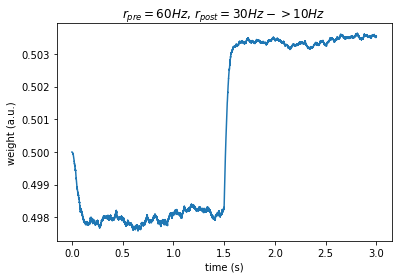

In [2]:
plt.plot(w_mon.t/second,mean(w_mon.w.T,1))
plt.xlabel('time (s)')
plt.ylabel('weight (a.u.)')
plt.title(r'$r_{pre}=%dHz$, $r_{post}=%dHz->%dHz$'%(rpre,rpost1,rpost2))
plt.show()


In [3]:
delay = []
for ii in range(int(N/10)):
    pret = pre_mon.t[pre_mon.i==ii]
    postt = post_mon.t[post_mon.i==ii]
    pret = pret[pret<(T/2)]
    postt = postt[postt<(T/2)]
    if ii%100==0:
        print(ii)
    for ti in postt:
        for tj in pret:
            delay.append((ti-tj)/second)



0
100
200
300
400


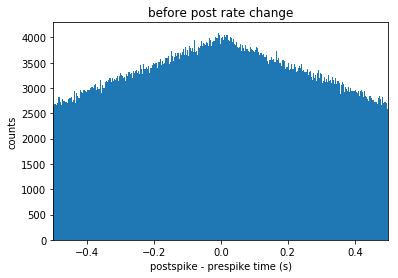

In [4]:
plt.hist(delay,bins=1000)
plt.xlabel('postspike - prespike time (s)')
plt.ylabel('counts')
plt.title('before post rate change')
plt.xlim((-0.5,0.5))
plt.show()

183.66539814543262

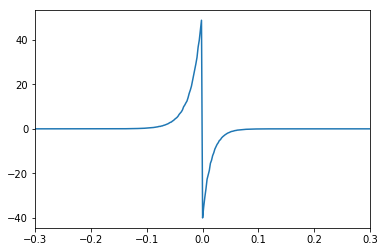

In [5]:
ddt = 0.002
TT = T/2/second
bins = np.arange(-TT-ddt/2,TT+ddt/2,ddt)
weightx = np.arange(-TT,TT,ddt)
kernel = t_back*np.exp(weightx*second/t_back)*(weightx<0) - t_forw*np.exp(-weightx*second/t_forw)*(weightx>=0)
h,_ = np.histogram(delay,bins)
wh = np.multiply(h,kernel)
plt.plot(weightx,wh)
plt.xlim((-0.3,0.3))
np.sum(wh)/second

-223.6733293688007

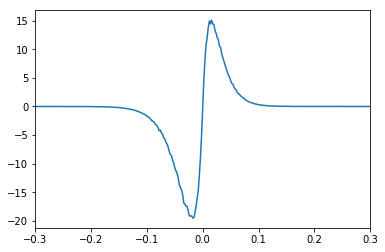

In [6]:
ddt = 0.002
TT = T/2/second
bins = np.arange(-TT-ddt/2,TT+ddt/2,ddt)
weightx = np.arange(-TT,TT,ddt)
kernel = weightx*np.exp(weightx*second/t_back)*(weightx<0) + weightx*np.exp(-weightx*second/t_forw)*(weightx>=0)
h,_ = np.histogram(delay,bins)
wh = np.multiply(h,kernel)
plt.plot(weightx,wh)
plt.xlim((-0.3,0.3))
np.sum(wh)